In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.optimize import root_scalar
from util import load_sample,load_acertos, provas, params_inep, irt_params_to_enem_scale,item_info_inep, scalecalparams, item_stats, PL3

%load_ext autoreload
%autoreload 2

# O modelo TRI funciona?
Um notebook para aferir se os ajustes feitos pelos INEP, usando o modelo PL3, funcionam bem na prática. Vamos comparar as curvas característas dos itens (a probabilidade de acerto $P(\theta|a,b,c)$ em função de $\theta$) com as curvas características empíricas (a fração dos candidatos que acertaram o item, para cada faixa de $\theta$). 

In [3]:
# Primeiro, uma função para recuperar os parâmetros TRI dos itens dado pelo INEP, 
# junto as estatísticas da teoria clássica de testes. Ambos já estã organizados na
# pasta ./data, feito no notebook 00-PrepareData
ano = 2019
def get_istats(ano,area=None):
    if area:
        areas=[area]
    else:
        areas = ['MT','CN','CH','LC']
    l=[]
    for area in areas:
        fn = f'data/istats-{ano}-{area}.csv'
        df = pd.read_csv(fn,index_col='item',dtype={'item':str})
        l.append(df)
    return pd.concat(l)


istats = get_istats(ano,'MT')
istats

,N,mean,sd,total.r,total.r_if_rm,alpha_if_rm,url,CO_POSICAO,SG_AREA,TX_GABARITO,...,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,ano,TP_LINGUA,IN_ITEM_ADAPTADO,TP_VERSAO_DIGITAL
item,,,,,,,,,,,,,,,,,,,,,
117783,63221,0.235286,0.424181,0.316867,0.245121,0.745935,https://www.curso-objetivo.br/vestibular/resol...,136,MT,B,...,NaN,1.96646,2.01615,0.15470,AMARELA,516,2019,NaN,0.0,NaN
83792,63221,0.199016,0.399263,0.326613,0.259605,0.745437,https://www.curso-objetivo.br/vestibular/resol...,137,MT,E,...,NaN,1.25552,1.93449,0.06675,AMARELA,516,2019,NaN,0.0,NaN
8442,63221,0.182186,0.386001,0.253335,0.186080,0.748372,https://www.curso-objetivo.br/vestibular/resol...,138,MT,D,...,NaN,1.51000,3.00300,0.14700,AMARELA,516,2019,NaN,0.0,NaN
117635,63221,0.543506,0.498108,0.360013,0.277543,0.744240,https://www.curso-objetivo.br/vestibular/resol...,136,MT,E,...,NaN,1.84162,0.88644,0.35048,AZUL,515,2019,NaN,0.0,NaN
9779,63221,0.152940,0.359932,0.219526,0.156055,0.749440,https://www.curso-objetivo.br/vestibular/resol...,137,MT,E,...,NaN,2.28700,2.21700,0.08500,AZUL,515,2019,NaN,0.0,NaN
111608,63221,0.181728,0.385623,0.497748,0.442269,0.738303,https://www.curso-objetivo.br/vestibular/resol...,138,MT,E,...,NaN,2.47366,1.61606,0.04665,AZUL,515,2019,NaN,0.0,NaN
111518,63221,0.333481,0.471460,0.400134,0.324574,0.742050,https://www.curso-objetivo.br/vestibular/resol...,136,MT,A,...,NaN,1.57287,1.15345,0.11072,ROSA,517,2019,NaN,0.0,NaN
83994,63221,0.291833,0.454610,0.466325,0.397960,0.738762,https://www.curso-objetivo.br/vestibular/resol...,137,MT,A,...,NaN,1.78432,1.16670,0.04550,ROSA,517,2019,NaN,0.0,NaN
63187,63221,0.480774,0.499634,0.424150,0.345470,0.740762,https://www.curso-objetivo.br/vestibular/resol...,136,MT,D,...,NaN,1.86876,0.42930,0.12552,CINZA,518,2019,NaN,0.0,NaN


In [4]:
# Temos as notas na escala ENEM, mas vamos trabalhar na "escala logit", 
def notas_to_logit_scale(notas,area):
    slope,intercept = scalecalparams(area)
    return (notas-intercept)/slope

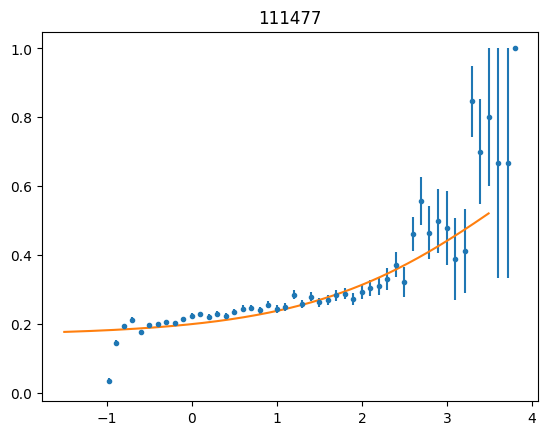

In [5]:
# A figura com a curva teórica sobreposto com a curva empírica
def item_notas(item,notas):
    ''
    ac = notas.loc[:,[item,'nota_inep','nota_inep_logit']]
    return ac

def itemplot(item,notas,graph='bubble',ax=None):
    if not ax:
        ax = plt.gca()
    acertosnotas = item_notas(item,notas)
    gb = acertosnotas.groupby(acertosnotas['nota_inep_logit'].apply(lambda x:round(x,1))).agg({item:['count','mean','std'],'nota_inep_logit':'mean'})
    gb.columns = ['count','mean','std','logit']
    gb['se'] = gb['std'] / np.sqrt(gb['count'])
    if graph == 'bubble':
        sns.scatterplot(gb,x='logit',y='mean',hue='count',size='count',sizes=(10, 300),ec="face",alpha=0.4,ax=ax,legend=False)
    else:
        plt.sca(ax)
        plt.errorbar(x=gb['logit'],y=gb['mean'],yerr=gb['se'],fmt='.')
    thetas = np.arange(-1.5,3.5,0.01)
    a,b,c = istats.loc[item][['NU_PARAM_A','NU_PARAM_B','NU_PARAM_C']]
    sns.lineplot(x=thetas,y=PL3(thetas,a,b,c),ax=ax)
    ax.set_title(item)

ano = 2018
area = 'MT'
istats = get_istats(ano,area)
item = random.choice(istats.index) # um item aleatório
#item = '48324'
notas = load_acertos(ano,area,perc=2)
notas['nota_inep_logit'] = notas_to_logit_scale(notas['nota_inep'],area)
itemplot(item,notas,graph='errorbar')


Agora que temos uma figura para 1 item, é mais fácil generalizar para todos os itens de um prova.

In [6]:
ano =2018
area = 'MT'
istats = get_istats(ano,area)
istats = istats.sort_values('NU_PARAM_B')

notas = load_acertos(ano,area,remove_abandonados=False)
notas  = notas.rename(lambda s: s.rstrip('-aban'),axis=1)
notas['nota_inep_logit'] = notas_to_logit_scale(notas['nota_inep'],area)

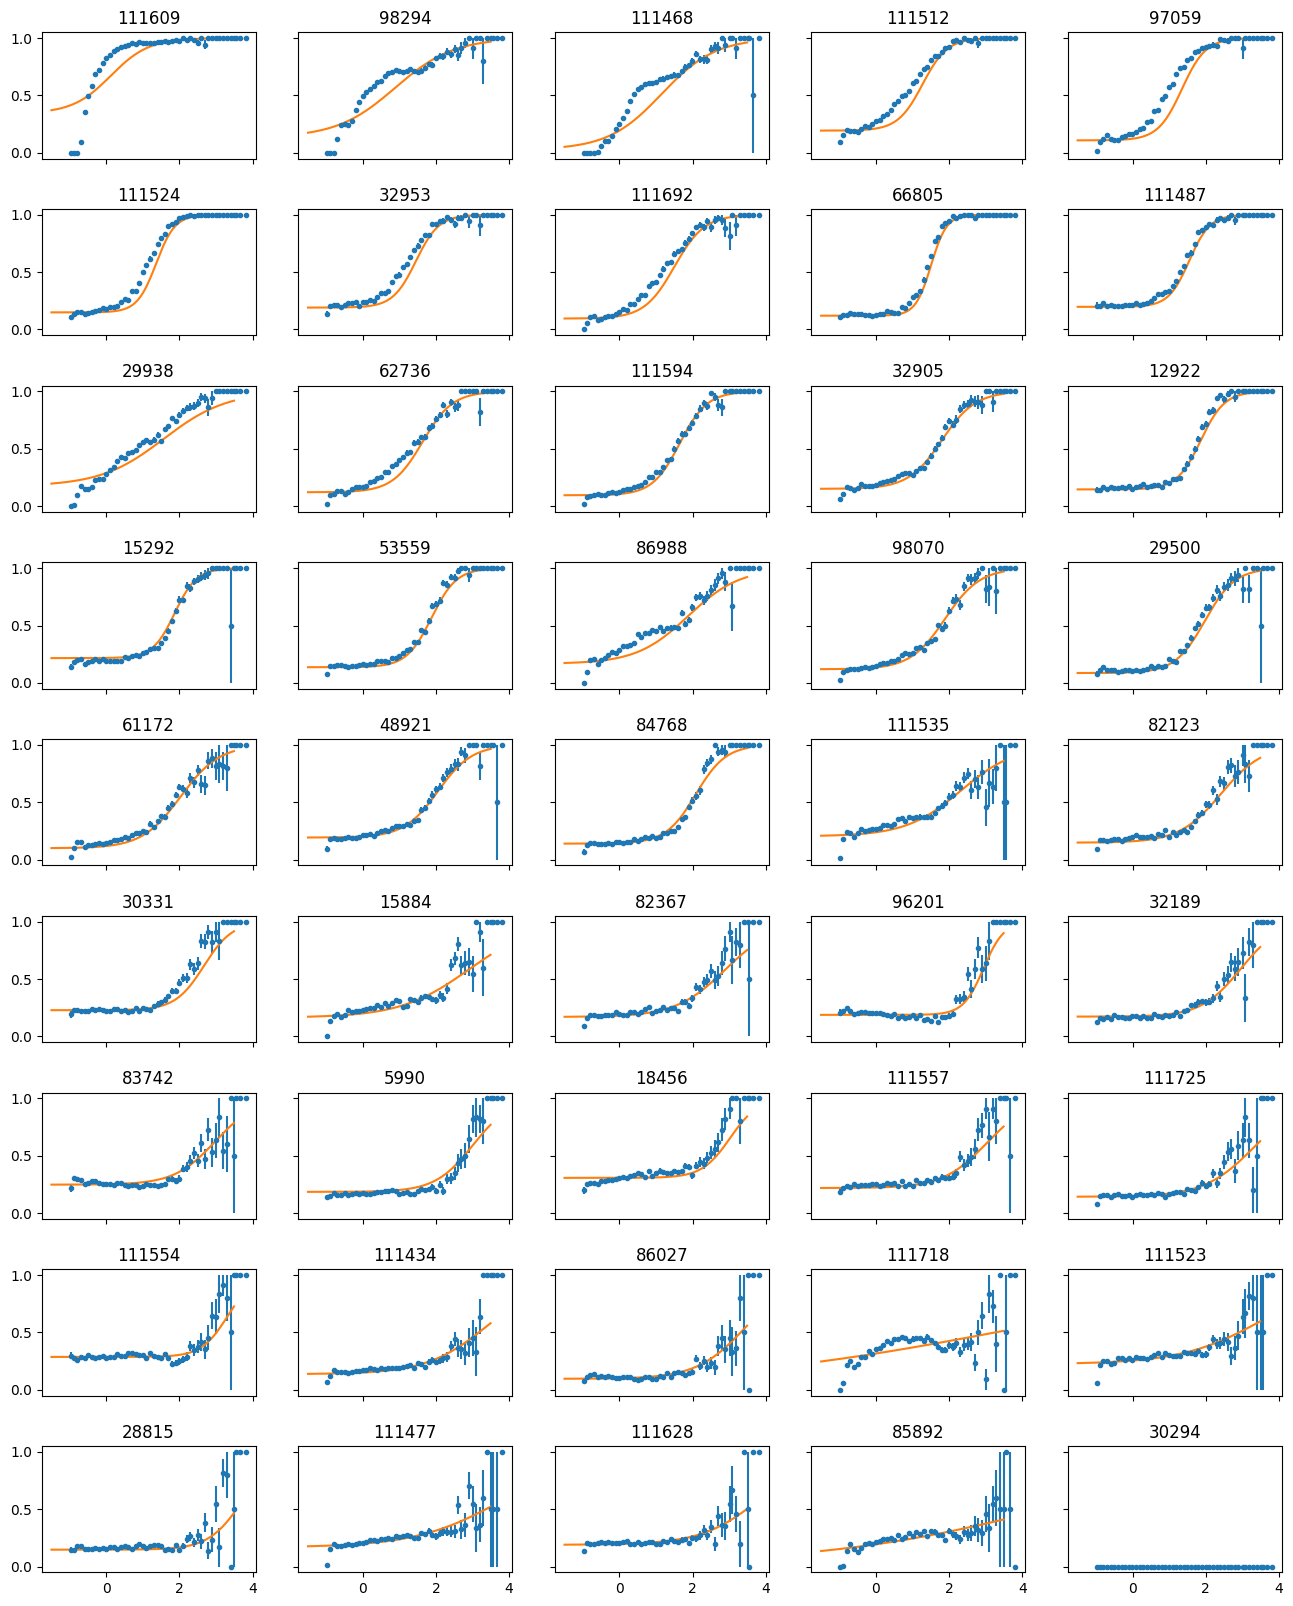

In [7]:
fig,axs = plt.subplots(9,5,sharex=True, sharey=True,figsize=(16,20))
i=0
for axrow in axs:
    for ax in axrow:
        item = istats.index[i]
        i = i + 1
        itemplot(item,notas,graph='xxx',ax=ax)
plt.subplots_adjust(hspace=0.4)

In [8]:
istats.index[-1]

'30294'

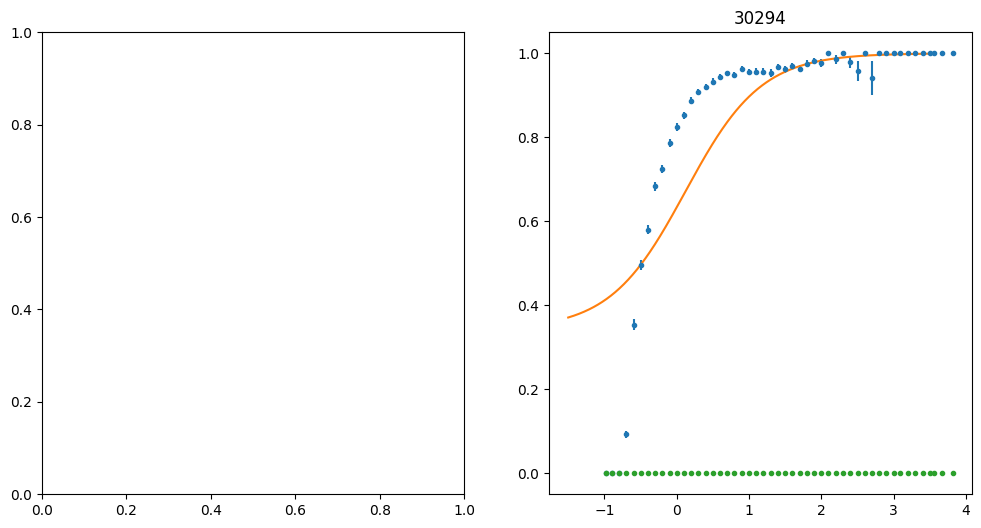

In [9]:
# O item mais fácil e o item mais difícil)
_, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
itemplot(istats.index[0],notas,ax1)
itemplot(istats.index[-1],notas,ax2)

In [19]:
istats

,N,mean,sd,total.r,url,CO_POSICAO,SG_AREA,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,ano,TP_LINGUA,IN_ITEM_ADAPTADO,TP_VERSAO_DIGITAL
item,,,,,,,,,,,,,,,,,,,,
41816,43959,0.597534,0.490400,0.333652,https://www.curso-objetivo.br/vestibular/resol...,178,MT,B,26.0,0,NaN,1.49174,-0.42299,0.19323,AMARELA,243,2015,NaN,0.0,NaN
41659,43959,0.496554,0.499994,0.401039,https://www.curso-objetivo.br/vestibular/resol...,138,MT,B,15.0,0,NaN,1.44654,-0.39957,0.20014,AMARELA,243,2015,NaN,0.0,NaN
14712,43959,0.574922,0.494360,0.358709,https://www.curso-objetivo.br/vestibular/resol...,180,MT,C,28.0,0,NaN,1.06024,-0.23853,0.20527,AMARELA,243,2015,NaN,0.0,NaN
33017,43959,0.328784,0.469777,0.422888,https://www.curso-objetivo.br/vestibular/resol...,141,MT,D,20.0,0,NaN,1.58698,0.56570,0.15746,AMARELA,243,2015,NaN,0.0,NaN
38013,43959,0.406128,0.491115,0.336009,https://www.curso-objetivo.br/vestibular/resol...,172,MT,D,17.0,0,NaN,1.22540,0.80613,0.17857,AMARELA,243,2015,NaN,0.0,NaN
26277,43959,0.340954,0.474035,0.397006,https://www.curso-objetivo.br/vestibular/resol...,143,MT,A,8.0,0,NaN,2.15675,0.94349,0.17590,AMARELA,243,2015,NaN,0.0,NaN
62901,43959,0.396574,0.489192,0.359697,https://www.curso-objetivo.br/vestibular/resol...,177,MT,E,1.0,0,NaN,1.54884,0.96427,0.24491,AMARELA,243,2015,NaN,0.0,NaN
54184,43959,0.365113,0.481467,0.371206,https://www.curso-objetivo.br/vestibular/resol...,154,MT,B,23.0,0,NaN,1.76806,1.06274,0.21458,AMARELA,243,2015,NaN,0.0,NaN
31374,43959,0.344412,0.475182,0.395721,https://www.curso-objetivo.br/vestibular/resol...,173,MT,B,16.0,0,NaN,2.75038,1.06733,0.22876,AMARELA,243,2015,NaN,0.0,NaN


In [157]:
item_info_inep(2019,'CN')

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,ano,TP_LINGUA,IN_ITEM_ADAPTADO,TP_VERSAO_DIGITAL
17930,91,CN,27903,D,27.0,0,NaN,2.13248,1.45511,0.18122,CINZA,544,2019,NaN,0.0,NaN
17931,91,CN,31718,D,28.0,0,NaN,1.90483,0.48421,0.21286,ROSA,506,2019,NaN,0.0,NaN
17932,91,CN,32818,C,2.0,0,NaN,1.61135,1.52847,0.12627,AMARELA,543,2019,NaN,0.0,NaN
17933,91,CN,82364,A,27.0,0,NaN,2.43167,1.13773,0.22233,AZUL,503,2019,NaN,0.0,NaN
17934,91,CN,89925,C,17.0,0,NaN,1.72007,0.75412,0.26095,ROSA,546,2019,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18375,135,CN,85112,E,30.0,0,NaN,2.37172,0.19119,0.10626,AMARELA,543,2019,NaN,0.0,NaN
18376,135,CN,96533,A,2.0,0,NaN,2.08707,1.27433,0.33679,CINZA,544,2019,NaN,0.0,NaN
18377,135,CN,97322,B,20.0,0,NaN,2.41465,1.28437,0.21462,AZUL,545,2019,NaN,0.0,NaN
18378,135,CN,97997,D,18.0,0,NaN,2.32257,0.47932,0.13509,ROSA,546,2019,NaN,0.0,NaN
